In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np

from utils.binance_loader import BinanceKlinesDownloader
from utils.visualizer_candles import CandleChartVisualizer
from utils.feature_generator import FeatureGenerator

In [3]:
binance_loader = BinanceKlinesDownloader()
candle_visualizer = CandleChartVisualizer(use_volume_width=False)
feature_generator = FeatureGenerator()

In [4]:
data = binance_loader.download(start_date='2025-04-05')

Чтение данных из кэша: binance_data_cache/BTCUSDT/BTCUSDT_1m_2025-04-05_to_2025-04-08.parquet.gz


In [5]:
candle_visualizer.plot_candlestick(data.iloc[:300])

In [21]:
features = feature_generator.transform(data)

Num nan values in EMA with span 20: 20
Num nan values in EMA with span 50: 50
Num nan values in EMA with span 100: 100
Num nan values in EMA with span 20: 20
Num nan values in EMA with span 12: 12
Num nan values in EMA with span 26: 26
Num nan values in EMA with span 9: 26


In [22]:
features.head()[['ema_base', 'close']]

,ema_base,close
0,83781.622476,83828.59
1,83782.638431,83792.29
2,83782.636675,83782.62
3,83781.506516,83770.77
4,83778.823991,83753.34


## ENV test

In [30]:
feature_states = np.array(features.state_vector.tolist())

In [40]:
feature_states.shape

(5414, 16)

In [31]:
from custom_envs.trading_env_v1 import TradingEnvV1

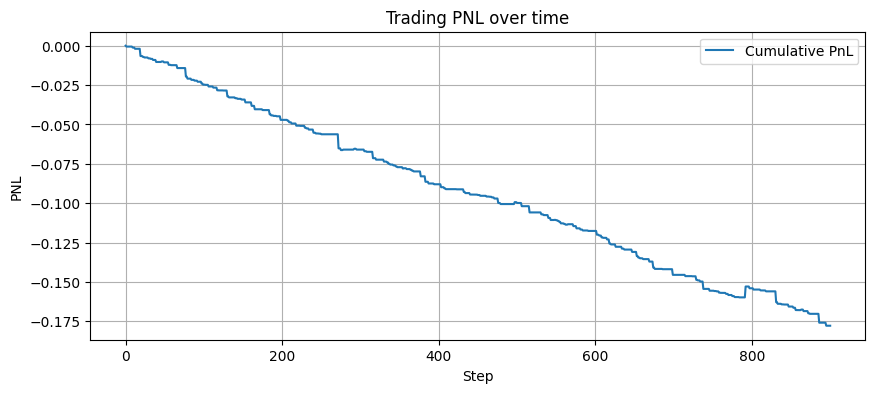

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Предположим, что features уже загружены
env = TradingEnvV1(features=feature_states)

obs, _ = env.reset()
done = False
rewards = []

for i in range(1000):
    possible_actions = env.get_possible_actions()
    action = np.random.choice(possible_actions)
    obs, reward, done, truncated, info = env.step(action)
    rewards.append(env.pnl)

    if i % 100 == 0:
        print(f"Step: {i}, Action: {action}, PnL: {env.pnl:.2f}")
        # Отрисовка графика
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        plt.plot(rewards, label='Cumulative PnL')
        plt.xlabel("Step")
        plt.ylabel("PNL")
        plt.title("Trading PNL over time")
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [43]:
import random
import numpy as np
from collections import deque

class DQNAgent:
    def __init__(
        self, state_dim, action_dim, lr=1e-3, gamma=0.99,
        batch_size=64, buffer_size=100_000, epsilon_start=1.0,
        epsilon_end=0.1, epsilon_decay=0.995
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size

        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)

        self.replay_buffer = deque(maxlen=buffer_size)

        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.q_network(state_tensor)
            return int(torch.argmax(q_values).item())

    def store(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0].detach()
        target = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [ ]:
import tqdm

def train_agent(env, agent, num_episodes=100, target_update_freq=10, t_max=1000):
    actions = []
    rewards_per_episode = []

    for episode in tqdm.trange(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for i in range(t_max):
            action = agent.act(state)
            actions.append(action)

            # можно использовать ограничение: choose only from env.get_possible_actions()
            state_next, reward, done, _, _ = env.step(action)
            agent.store(state, action, reward, state_next, done)
            agent.train_step()
            state = state_next
            total_reward += reward

        if episode % target_update_freq == 0:
            agent.update_target_network()

        rewards_per_episode.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    return rewards_per_episode, actions

In [47]:
comission = 0.0001
epsilon_decay=0.9999
t_max = 2000

In [ ]:
env = TradingEnvV1(features=feature_states, commission=comission)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, epsilon_decay=epsilon_decay, gamma=0.97)
rewards = train_agent(env, agent, num_episodes=100, t_max=t_max, target_update_freq=5)

  1%|          | 1/100 [00:04<06:41,  4.05s/it]

Episode 0, Total Reward: -0.07, Epsilon: 0.824


 11%|█         | 11/100 [00:45<05:47,  3.90s/it]

Episode 10, Total Reward: -0.02, Epsilon: 0.111


 21%|██        | 21/100 [01:25<05:19,  4.04s/it]

Episode 20, Total Reward: -0.01, Epsilon: 0.100


 31%|███       | 31/100 [02:08<05:13,  4.55s/it]

Episode 30, Total Reward: 0.00, Epsilon: 0.100


 37%|███▋      | 37/100 [02:36<04:52,  4.64s/it]

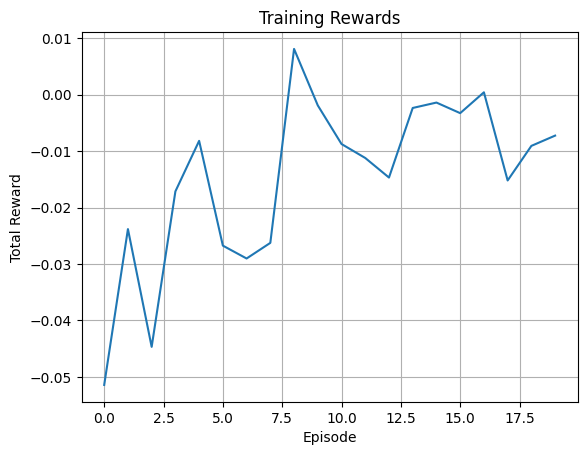

In [64]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.grid(True)
plt.show()


In [52]:
test_features = feature_states[-1000:]

In [60]:
test_env = TradingEnvV1(features=feature_states, commission=comission)

In [61]:
def evaluate_agent(agent, env, render=False, t_max=1000):
    state, _ = env.reset()
    done = False
    total_reward = 0.0
    pnl_curve = []
    prices = []
    actions = []

    while not done or t_max > 0:
        t_max -= 1
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = agent.q_network(state_tensor)
            action = int(torch.argmax(q_values).item())
            
        

        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        pnl_curve.append(env.pnl)
        prices.append(env._get_current_price())
        actions.append(action)

        if render:
            from IPython.display import clear_output
            clear_output(wait=True)
            plt.figure(figsize=(10, 4))
            plt.plot(pnl_curve, label='Cumulative PnL')
            plt.title("Test PnL")
            plt.grid()
            plt.legend()
            plt.show()

    return total_reward, pnl_curve, prices, actions

In [62]:
total_pnl, pnl_curve, prices, actions = evaluate_agent(agent, test_env, render=True)

print(f"Total PnL on test set: {total_pnl:.2f}")

KeyboardInterrupt: 

In [59]:
pd.Series(actions).value_counts()

0    999
Name: count, dtype: int64